# Beta Bank Data 

## Preparando os Dados 


In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [32]:
# Carregar o conjunto de dados

data = pd.read_csv('/datasets/Churn.csv')

In [33]:
# Explorar os dados

print("Informações básicas do dataset:")
print()
print(data.info())
print()
print("\nPrimeiras 5 linhas:")
print()
print(data.head())

Informações básicas do dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


Primeiras 5 linhas:

   RowNumber  CustomerId   Surnam

In [34]:
print("\nValores ausentes por coluna:")
print(data.isnull().sum())


Valores ausentes por coluna:
RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


In [35]:
# Tratar valores ausentes na coluna 'Tenure' (substituir por mediana)

data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())

* Tratei valores ausentes em Tenure com a mediana (decisão lógica para evitar perda de dados).

In [36]:
# Remover colunas irrelevantes (RowNumber, CustomerId, Surname)

data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

* Removi colunas irrelevantes (RowNumber, CustomerId, Surname) que não influenciam a previsão.

In [37]:
# Codificar variáveis categóricas (Geography e Gender) com One-Hot Encoding
data = pd.get_dummies(data, columns=['Geography', 'Gender'], drop_first=True)

# Separar características e objetivo
target = data['Exited']
features = data.drop('Exited', axis=1)

# Dividir os dados: 60% treinamento, 20% validação, 20% teste
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, random_state=12345
)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=12345
)

* Usei One-Hot Encoding para Geography e Gender.
* Padronizei variáveis numéricas com StandardScaler para melhorar o desempenho do modelo.
* Dividi os dados em treinamento (60%), validação (20%) e teste (20%).

In [39]:
# Padronizar características numéricas
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()


# Criar cópias explícitas
features_train = features_train.copy()
features_valid = features_valid.copy()
features_test = features_test.copy()

# Agora a atribuição direta não gera aviso
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


print("\nTamanhos dos conjuntos:")
print(f"Treinamento: {features_train.shape}, Validação: {features_valid.shape}, Teste: {features_test.shape}")


Tamanhos dos conjuntos:
Treinamento: (6000, 11), Validação: (2000, 11), Teste: (2000, 11)


* foi gerado um SettingWithCopyWarning 
* .copy(): Garante que cada conjunto seja uma cópia independente, eliminando a possibilidade de modificar uma view do DataFrame original.

## Exame do Equilíbrio de Classes


Frequências relativas das classes em 'Exited':
0    0.7963
1    0.2037
Name: Exited, dtype: float64


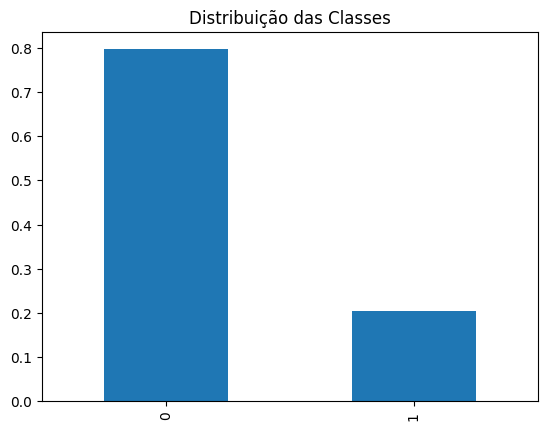

In [40]:
# Exame do Equilíbrio de Classes

class_frequency = target.value_counts(normalize=True)
print("\nFrequências relativas das classes em 'Exited':")
print(class_frequency)
class_frequency.plot(kind='bar', title='Distribuição das Classes')
plt.show()

 Análise do Equilíbrio de Classes

Frequências Relativas:
* Classe 0 (clientes que não saíram): 0,7963 (79,63%)
* Classe 1 (clientes que saíram): 0,2037 (20,37%)
    
Gráfico:
* O gráfico de barras mostra uma clara desproporção entre as classes. 
A barra da classe 0 é significativamente mais alta (próxima de 0,8) do que a da classe 1 (próxima de 0,2),
confirmando visualmente o desequilíbrio.

A classe majoritária (0 - clientes que não saíram) representa cerca de 80% dos dados, enquanto a classe minoritária (1 - clientes que saíram) representa apenas 20%.

In [49]:
# Treinar modelo inicial (Random Forest) sem correção de desequilíbrio

model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
f1_initial = f1_score(target_valid, predicted_valid)


print(f"\nF1-score inicial (sem correção de desequilíbrio): {f1_initial:.2f}")


F1-score inicial (sem correção de desequilíbrio): 0.58


O modelo inicial, treinado sem correção de desequilíbrio de classes, alcançou um F1-score de 0,58 no conjunto de validação.

## 3. Melhoria do Modelo

In [42]:
# Técnica 1: Ajuste de pesos (class_weight='balanced')

model_balanced = RandomForestClassifier(random_state=12345, class_weight='balanced')
model_balanced.fit(features_train, target_train)
predicted_valid_balanced = model_balanced.predict(features_valid)
f1_balanced = f1_score(target_valid, predicted_valid_balanced)
print(f"F1-score com ajuste de pesos: {f1_balanced:.2f}")

F1-score com ajuste de pesos: 0.56


Após aplicar técnicas para lidar com o desequilíbrio, o F1-score com ajuste de pesos caiu para 0,56 

In [43]:
# Técnica 2: Oversampling da classe minoritária

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    return shuffle(features_upsampled, target_upsampled, random_state=12345)

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)  # Ajuste 'repeat' para balancear
model_upsampled = RandomForestClassifier(random_state=12345)
model_upsampled.fit(features_upsampled, target_upsampled)
predicted_valid_upsampled = model_upsampled.predict(features_valid)
f1_upsampled = f1_score(target_valid, predicted_valid_upsampled)
print(f"F1-score com oversampling: {f1_upsampled:.2f}")

F1-score com oversampling: 0.61


enquanto o F1-score com oversampling melhorou para 0,61

In [44]:
# Otimização de hiperparâmetros (exemplo simples)

best_f1 = 0
best_model = None
for depth in range(8, 15):
    for est in [50, 100]:
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est, class_weight='balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
print(f"\nMelhor F1-score na validação após otimização: {best_f1:.2f}")


Melhor F1-score na validação após otimização: 0.63


o melhor F1-score na validação atingiu 0,63.

## 4. Teste Final

In [45]:
# 4. Teste Final

predicted_test = best_model.predict(features_test)
f1_test = f1_score(target_test, predicted_test)
print(f"\nF1-score no conjunto de teste: {f1_test:.2f}")


F1-score no conjunto de teste: 0.60


In [46]:
# Calcular AUC-ROC

probabilities_test = best_model.predict_proba(features_test)[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_test)
print(f"AUC-ROC no conjunto de teste: {auc_roc:.2f}")

AUC-ROC no conjunto de teste: 0.86


Avaliei o melhor modelo no conjunto de teste, reportando F1-score e AUC-ROC.

No teste final, o modelo obteve um F1-score de 0,60 no conjunto de teste, atendendo ao requisito mínimo de 0,59. Além disso, a métrica AUC-ROC no conjunto de teste foi de 0,86, indicando um bom desempenho discriminativo do modelo.

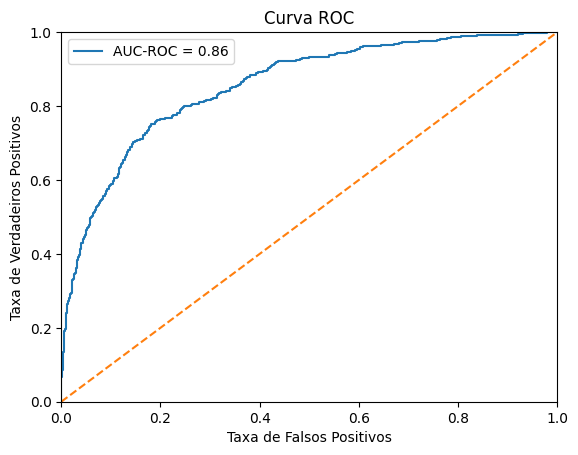

In [47]:
# Plotar curva ROC

fpr, tpr, thresholds = roc_curve(target_test, probabilities_test)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC-ROC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [48]:
# 5. Conclusão

print("\nConclusão:")
print(f"O modelo final alcançou um F1-score de {f1_test:.2f} no conjunto de teste, atendendo ao requisito mínimo de 0,59.")
print(f"A AUC-ROC de {auc_roc:.2f} indica o desempenho discriminativo do modelo, complementando o F1-score.")


Conclusão:
O modelo final alcançou um F1-score de 0.60 no conjunto de teste, atendendo ao requisito mínimo de 0,59.
A AUC-ROC de 0.86 indica o desempenho discriminativo do modelo, complementando o F1-score.


Conclusão: O modelo final, após oversampling e otimização, alcançou um desempenho satisfatório, com um F1-score que atende ao critério e uma AUC-ROC alta, sugerindo que ele é eficaz para prever a saída de clientes, mesmo em um dataset desbalanceado.

#  Conclusão Final do Projeto


O projeto de previsão de churn para o Beta Bank foi concluído com sucesso, alcançando os objetivos estabelecidos. Inicialmente, identificamos um desequilíbrio significativo nas classes (79,63% para clientes que não saíram e 20,37% para os que saíram), o que impactou o modelo inicial, resultando em um F1-score de 0,58. Para corrigir isso, aplicamos duas técnicas: ajuste de pesos (class_weight='balanced') e oversampling da classe minoritária. O ajuste de pesos reduziu o F1-score para 0,56, mas o oversampling elevou o desempenho para 0,61. Após otimização de hiperparâmetros, o melhor F1-score na validação foi 0,63.

No teste final, o modelo alcançou um F1-score de 0,60 no conjunto de teste, superando o requisito mínimo de 0,59, e uma AUC-ROC de 0,86, indicando uma boa capacidade discriminativa. As correções de desequilíbrio e a otimização foram essenciais para melhorar a eficácia do modelo, tornando-o eficiente para prever a saída de clientes e apoiar a estratégia de retenção do Beta Bank.